# Abberation mapping workflow 1: Process patches #

*25 January 2023*

*11 September 2023*

*27 September 2023*

Originally by Debayan Saha.  Jamie White modified Debayan's notebooks. 

Updating for Jamie's environment on the cluster.

Documenting installation / file locations.

Updating to run notebooks locally on a Mac / PC.  The psf modeling is super compute intensive, so it needs to be done on the cluster. Strategy: execute cluster commands via ssh.

**Logistics**

1. Copy the folder `patches_for_zola` to the remote using ssh (needs to be set up with ssh passkeys between local and remote (falcon). Remove the `patches_for_zola` folder from the remote before copying, if it exists. 
2. slurm calls a bashscript shell script to initialize processes on the cluster: <br> `sbatch {remote_project_path}/scripts/bashscript3.sh`
2. In turn, the bash script sets up slurm jobs on gpu nodes of the cluster and calls ImageJ to run a macro stored in the variable `remote_fiji_macro_path` in headless batch mode.
3. The ImageJ macro runs the "Calibration: PSF modeling" plugin from the with the parameters stored in the `imageJ_macro_parameters` variable.  The macro should **not** need to be modified for each experiment.
4. The ImageJ plugin models the zola_raw data for each bead in the `zola_raw` folder
5. Copy the `zola_raw` folder from the cluster to the local machine using sftp and paramiko. 

## Environment paths ##

Not necessary in local non-cuda environment; transfer these to script executed via ssh.

In [1]:
# # not necessary for running locally on a mac  
# %env PATH=/sw/ap|ps/python3/3.7.4/bin:/sw/apps/jupyter-tensorboard/0.1.6/bin:/sw/apps/hdf5/1.8.16/bin:/sw/apps/cuda/10.0.130/bin:/sw/bin:/usr/lib64/qt-3.3/bin:/sbin:/bin:/usr/sbin:/usr/bin
# %env LD_LIBRARY_PATH=/sw/apps/python3/3.7.4/lib:/sw/apps/hdf5/1.8.16/lib:/sw/apps/cuda/10.0.130/lib64:/sw/apps/cuda/10.0.130/lib:/sw/lib

In [2]:
# ! env

## Load packages ##

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(".")
# sys.path.append('/home/dsaha/.local/lib/python3.7/site-packages/')
from main import *
import os
import shlex
import paramiko
import tifffile
import shutil
import warnings
import tqdm
from IPython.display import display, clear_output
from time import sleep

In [4]:
warnings.filterwarnings(action='once')
%load_ext autoreload
%autoreload 2

### Files ###
|
Change the files for the experiment here.

In [5]:
# relative path to bead image stack
# image_file = "data/andrea/2022_09_06_Beads_0p2_2ndfloorscope_test/beads.tif"
image_file = "data/andrea/0p5mkBeadsDICHmirror_4_test/0p5mk.tif"

In [6]:
# ImageJ executable location on **cluster**
remote_fiji_path = '/home/jwhite/fiji/Fiji.app/ImageJ-linux64'
# project location on cluster
# project files are relative to this location
# and should be duplicated on the local machine
remote_project_base_path = '/home/jwhite/projects/aberration_mapping/'
# macro location: relative, for both machines
fiji_macro_dir  =  "imageJ_macros/" 
# select proper macro 
fiji_macro      = 'zola_macro_cluster_params_passed.ijm'# path to custom macros for running on cluster

In [7]:
# script for starting zola analysis on cluster
zola_script_dir = 'scripts/'
# script to use
# bashscript_fiji3.sh currently accepts paramters defined in this notebook and does not need to be edited for each analysis
zola_script     = 'bashscript_fiji3.sh'

### Parameters ###

Change the paramters for the experiment here.

In [8]:
# set new parameters
crop_shape      = [40, 40, 40]
unit            = [0.1, 0.1, 0.1]
abb_list        = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
thresh_bck      = 10
num_folders     = 50
thresh_dist     = 11.29999999999999999999999999999999999
lam             = 0.515

# for psf macro
pixel_size           = 200 # pixel size in nanometers
z_step               = 50 # spacing of the z-slices, in nanometers
bead_moving          = "far -> close to objective"
immersion_refractive = 1.33
numerical_aperture   = 1.2  # NA of objective used to image beads
patch_size           = 64
zernike_coefficient  = "Zernike 15 coefs"
iteration            = 20

In [9]:
# construct parameter string for the psf modeling ImageJ plugin 
# to be called on a gpu node of the HPC cluster by slurm
'''
run(" Calibration: PSF modeling", " run_on_gpu gain=1 pixel_size=100 z_step=50 bead_moving=[{bead_moving}] numerical_aperture=1.2 immersion_refractive=1.33 wavelength={lam} patch_size="+wid+" zernike_coefficient=[Zernike 15 coefs] iteration=100 result_calibration_file="+output);
'''
#use the gpu
imageJ_macro_parameters = f'run_on_gpu gain=1 pixel_size={pixel_size} z_step={z_step} bead_moving=[{bead_moving}] numerical_aperture={numerical_aperture} immersion_refractive={immersion_refractive} wavelength={lam} patch_size={patch_size} zernike_coefficient=[{zernike_coefficient}] iteration={iteration} result_calibration_file='
# no gpu
# imageJ_macro_parameters = f'gain=1 pixel_size={pixel_size} z_step={z_step} bead_moving=[{bead_moving}] numerical_aperture={numerical_aperture} immersion_refractive={immersion_refractive} wavelength={lam} patch_size={patch_size} zernike_coefficient=[{zernike_coefficient}] iteration={iteration} result_calibration_file='

imageJ_macro_parameters = f"\"{imageJ_macro_parameters}\""
# print(imageJ_macro_parameters)
# spaces are causing problems when passed to command line, so use "Q" as a spacer
# the > is also problematic, replace with R
imageJ_macro_parameters = imageJ_macro_parameters.replace(" ", "Q").replace(">", "R")
imageJ_macro_parameters

'"run_on_gpuQgain=1Qpixel_size=200Qz_step=50Qbead_moving=[farQ-RQcloseQtoQobjective]Qnumerical_aperture=1.2Qimmersion_refractive=1.33Qwavelength=0.515Qpatch_size=64Qzernike_coefficient=[ZernikeQ15Qcoefs]Qiteration=20Qresult_calibration_file="'

## Utility functions ##

In [10]:
def pretty_print_dict(d):
    print(json.dumps(d, indent=4))
    
def min_max_norm(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

## Initialize paramiko for ssh and sftp connections

In [11]:
# SSH Configuration
hostname = 'falcon'
port = 22  # default SSH port, change if needed
username = 'jwhite'
# 
# local_file_path = '~/data/mydatafile.txt'
# remote_file_path = '~/data/mydatafile.txt'

# Use the private key for authentication
private_key_path = os.path.expanduser("~/.ssh/id_rsa")
private_key = paramiko.RSAKey(filename=private_key_path)

# Initialize SSH client
ssh_client = paramiko.SSHClient()
ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())  # auto-accept the server's host key

___

## Generate additional files and parameters ##

The notebook assumes everything is set locally and tries to reproduce the local project space on the remote `falcon` using the `paramiko` python package.

## Construct local filepaths ##

From current working directory. 

In [12]:
local_base_path = os.getcwd()+'/' # everything relative to the notebook directory
local_base_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/'

In [13]:
local_fiji_macro_path = f'{local_base_path}{fiji_macro_dir}{fiji_macro}'
local_fiji_macro_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/imageJ_macros/zola_macro_cluster_params_passed.ijm'

In [14]:
# construct full path to image file and set save directory
local_img_path  = f"{local_base_path}{image_file}"
local_img_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/0p5mk.tif'

In [15]:
# file_path and save_dir variables for compatibility
local_data_file_path = os.path.dirname(local_img_path) +'/'
Local_save_dir  = local_data_file_path
local_data_file_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/'

In [16]:
local_zola_script_path = f"{local_base_path}{zola_script_dir}{zola_script}"
local_zola_script_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/scripts/bashscript_fiji3.sh'

In [17]:
local_patches_path= f'{local_data_file_path}patches_for_zola/'
local_patches_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/'

## Construct remote filepaths ##

In [18]:
remote_project_base_path

'/home/jwhite/projects/aberration_mapping/'

In [19]:
remote_image_file_path = f"{remote_project_base_path}{image_file}"
remote_image_file_path

'/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/0p5mk.tif'

In [20]:
remote_fiji_macro_path = f'{remote_project_base_path}{fiji_macro_dir}{fiji_macro}'
remote_fiji_macro_path

'/home/jwhite/projects/aberration_mapping/imageJ_macros/zola_macro_cluster_params_passed.ijm'

In [21]:
# construct full path to image file and set save directory
remote_img_path  = f"{remote_project_base_path}{image_file}"
remote_img_path

'/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/0p5mk.tif'

In [22]:
# file_path and save_dir variables for compatibility
remote_data_file_path = os.path.dirname(remote_img_path) +'/'
remote_save_dir  = remote_data_file_path
remote_data_file_path

'/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/'

In [23]:
remote_zola_script_path = f"{remote_project_base_path}{zola_script_dir}{zola_script}"
remote_zola_script_path

'/home/jwhite/projects/aberration_mapping/scripts/bashscript_fiji3.sh'

In [24]:
remote_patches_path = f'{remote_data_file_path}patches_for_zola/'
remote_patches_path

'/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/'

## Construct new parameters dictionary ##

In [25]:
# parameters
new_parameters = {}

new_parameters['crop_shape']      = crop_shape
new_parameters['unit']            = unit
new_parameters['abb_list']        = abb_list
new_parameters['FIJI_MACRO_PATH'] = remote_fiji_macro_path
new_parameters['thresh_bck']      = thresh_bck
new_parameters['num_folders']     = num_folders
new_parameters['thresh_dist']     = thresh_dist
new_parameters['lam']             = lam
new_parameters

{'crop_shape': [40, 40, 40],
 'unit': [0.1, 0.1, 0.1],
 'abb_list': [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'FIJI_MACRO_PATH': '/home/jwhite/projects/aberration_mapping/imageJ_macros/zola_macro_cluster_params_passed.ijm',
 'thresh_bck': 10,
 'num_folders': 50,
 'thresh_dist': 11.3,
 'lam': 0.515}

## Make sure everything we need is on the remote

In [26]:
# local project space will be reconstructed relative to this directory on the remote
remote_project_base_path

'/home/jwhite/projects/aberration_mapping/'

In [27]:
# compare to local project space
local_base_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/'

In [28]:
# check that the project folder is the same on both systems
local_project_check = local_base_path.split('/')[-2]
remote_project_check = remote_project_base_path.split('/')[-2]
assert local_project_check == remote_project_check,  "Local and remote base project spaces are not the same.  Are you sure about this?"

In [29]:
# copy local files over if they are not there already

local_file_paths = [
    local_img_path,
    local_fiji_macro_path,
    local_zola_script_path
]

remote_file_paths = [
    remote_image_file_path,
    remote_fiji_macro_path,
    remote_zola_script_path
]

# open ssh connection
ssh_client.connect(hostname, port, username, pkey=private_key)

# Initialize SFTP client
sftp_client = ssh_client.open_sftp()

# check for ImageJ on remote

try:
    sftp_client.stat(remote_fiji_path)
    print(f"Using {remote_fiji_path} on the remote system {hostname}")
    print()
except FileNotFoundError:
    print(f"Cannot find {remote_fiji_path} on {hostname}.  Perhaps it is not installed?")
    print()
    
    
for local, remote in list(zip(local_file_paths, remote_file_paths)):
    # 1. Check if the remote file exists
    try:
        sftp_client.stat(remote)
        print(f"Remote file \n {remote} \nalready exists. Nothing copied.")
    except FileNotFoundError:
     # 2. If it does not exist, copy the local file to the remote location
        sftp_client.put(local, remote)
        print(f"Local file {local} copied to {remote} on the remote server.")
    
# Close the clients
sftp_client.close()
ssh_client.close()

Using /home/jwhite/fiji/Fiji.app/ImageJ-linux64 on the remote system falcon

Remote file 
 /home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/0p5mk.tif 
already exists. Nothing copied.
Remote file 
 /home/jwhite/projects/aberration_mapping/imageJ_macros/zola_macro_cluster_params_passed.ijm 
already exists. Nothing copied.
Remote file 
 /home/jwhite/projects/aberration_mapping/scripts/bashscript_fiji3.sh 
already exists. Nothing copied.


## Fiji application and ImageJ macros

### Check Fiji macros ###

In [30]:
# # check current macro directory
# fiji_macro_dir

In [31]:
# fiji_macro_path

In [32]:
# # check available macros
# ! ls -lga "{fiji_macro_dir}"

## Check old parameters if they exist

In [33]:
# # look at parameters from last processing job
# old_params = setup_param_file(local_img_path)
# type(old_params)
# old_params

## Load and show the image

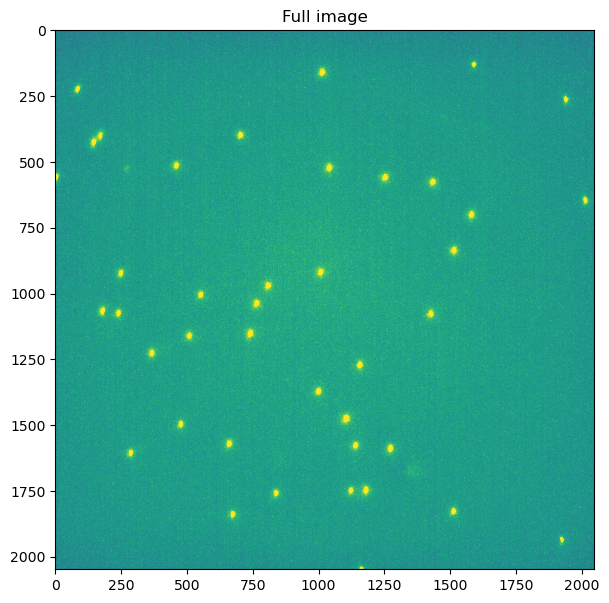

In [34]:
img = tifffile.imread(local_img_path)
img_max = np.max(img,0)

%matplotlib inline
fig, axs = plt.subplots(1,1,figsize=(10,7))
plt.imshow(img_max, clim=(np.percentile(img_max,0), np.percentile(img_max,99)))
plt.title("Full image");
# None;

## Load points from csv file and save patches

In [35]:
# from main import *
find_psf_crops(
    local_img_path, 
    crop_shape     = crop_shape, 
    num_folders    = num_folders, 
    thresh_bck     = thresh_bck, 
    threshold_dist = thresh_dist,
    unit           = unit,
    show_ignored   = False, 
    show_accepted  = False, 
    headless       = False
)

Found 39 points
Deleting 0 because points are too close
Deleting 1 because patches could not be cropped
Deleting because of label touching bounidng box
Processed 38 patches
saved 37 patches
Rejected 1 patches


## Load patches

In [36]:
# load the patches
patch_files = glob.glob(f"{os.path.dirname(local_img_path)}/patches_for_zola/patches*/planes_10_*.tif")
print(f"Found {len(patch_files)} patch files")
names = [os.path.splitext(os.path.basename(p))[0] for p in patch_files]
crops = {n: tifffile.imread(p) for n, p in zip(names, patch_files)}
pos = np.array([list(map(int, re.findall(r'\d+', n))) for n in names])
pos = pos[:,1:]

Found 37 patch files


In [37]:
patch_files[:2]

['/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/patches_34/planes_10_z_34_y_1151_x_742.tif',
 '/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/patches_33/planes_10_z_36_y_523_x_1042.tif']

## Show the beads

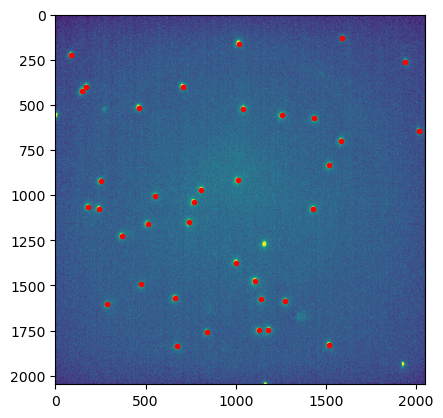

In [38]:
plt.imshow(img_max, clim=(np.percentile(img_max,3), np.percentile(img_max,99)))
plt.plot(pos[:,2], pos[:,1],'r.');

## Show each bead

planes_10_z_34_y_1151_x_742 169.0


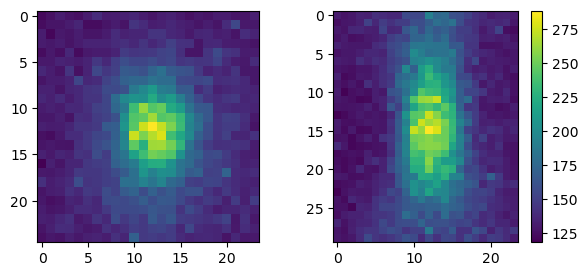

(30, 25, 24)
planes_10_z_36_y_523_x_1042 154.0


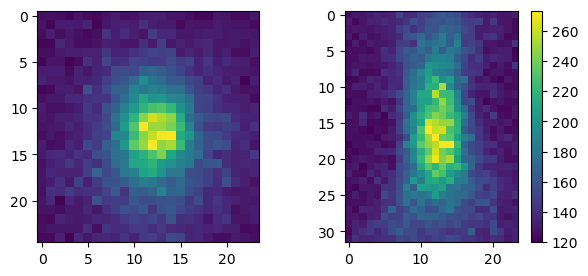

(32, 25, 24)
planes_10_z_25_y_1828_x_1514 145.0


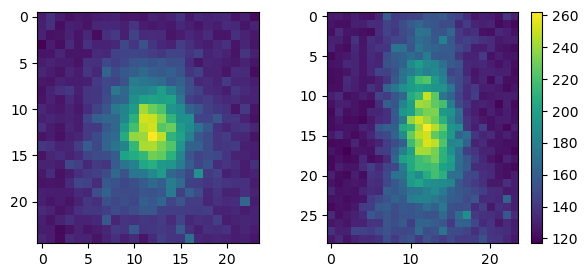

(29, 25, 24)
planes_10_z_29_y_1746_x_1181 169.0


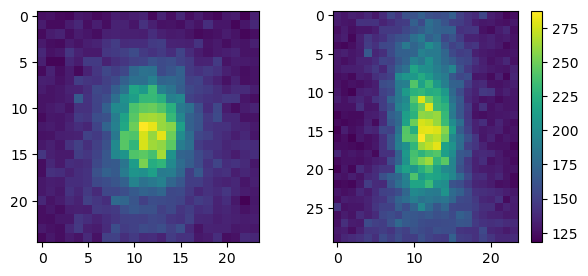

(30, 25, 24)
planes_10_z_33_y_130_x_1591 116.0


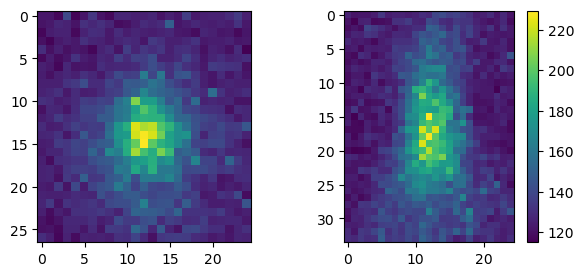

(34, 27, 25)
planes_10_z_38_y_425_x_148 155.0


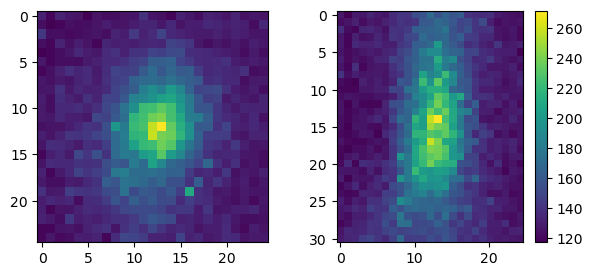

(31, 25, 25)
planes_10_z_29_y_1077_x_1428 152.0


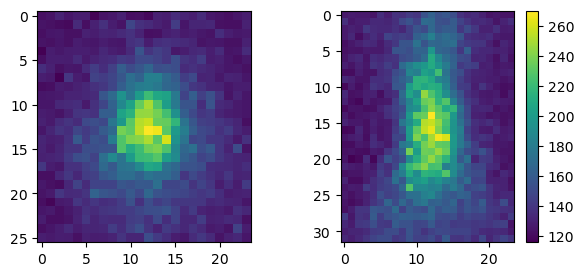

(32, 26, 24)
planes_10_z_29_y_1577_x_1141 154.0


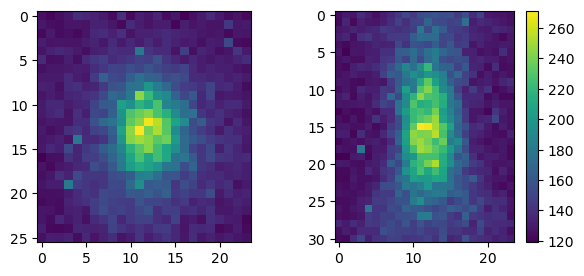

(31, 26, 24)
planes_10_z_42_y_224_x_85 134.0


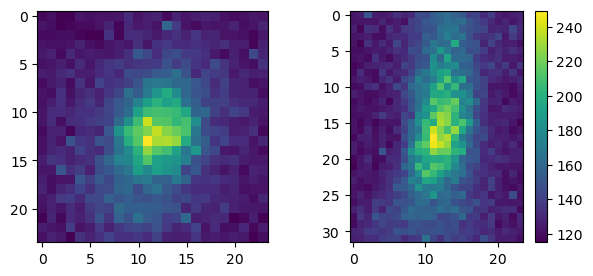

(32, 24, 24)
planes_10_z_32_y_701_x_1581 183.0


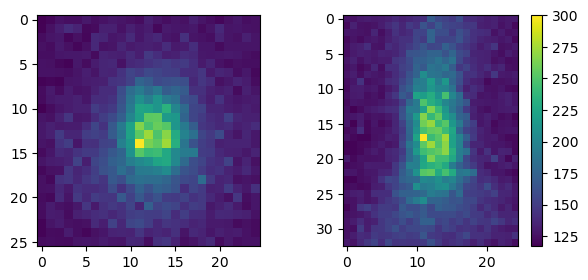

(33, 26, 25)
planes_10_z_32_y_1569_x_661 143.0


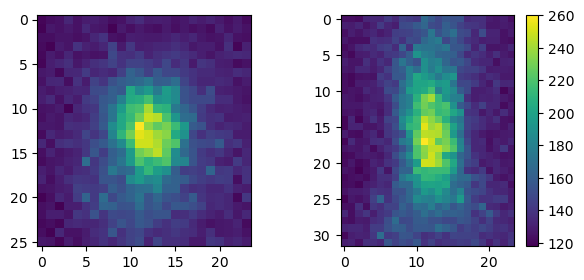

(32, 26, 24)
planes_10_z_37_y_558_x_1254 162.0


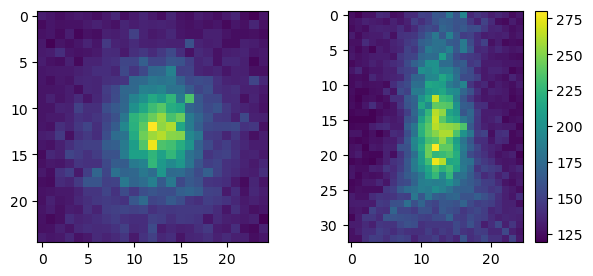

(33, 25, 25)
planes_10_z_33_y_574_x_1435 167.0


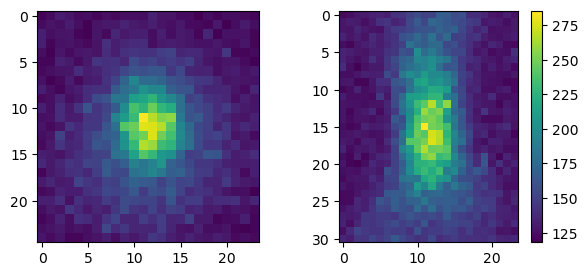

(31, 25, 24)
planes_10_z_37_y_398_x_706 145.0


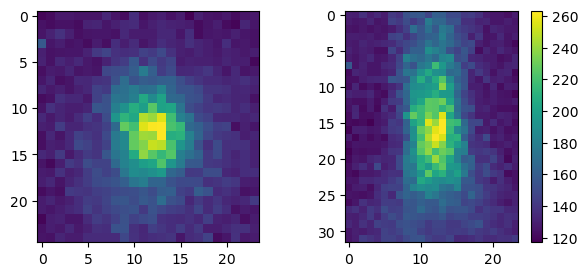

(32, 25, 24)
planes_10_z_29_y_1475_x_1106 177.0


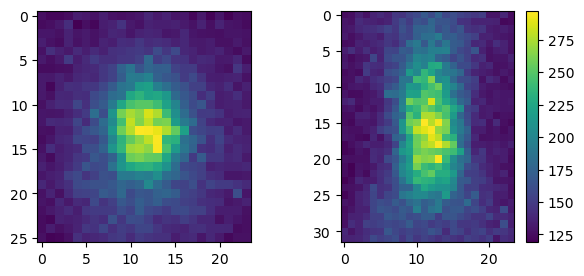

(32, 26, 24)
planes_10_z_29_y_1749_x_1126 158.0


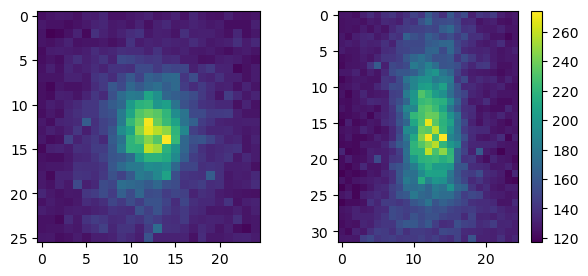

(32, 26, 25)
planes_10_z_30_y_1838_x_675 142.0


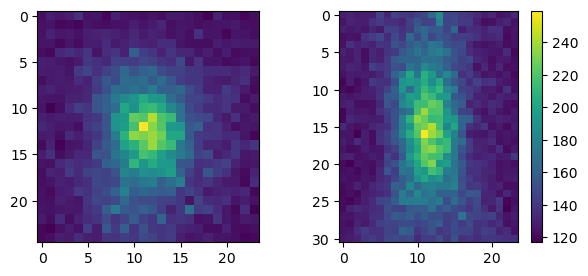

(31, 25, 24)
planes_10_z_30_y_645_x_2013 125.0


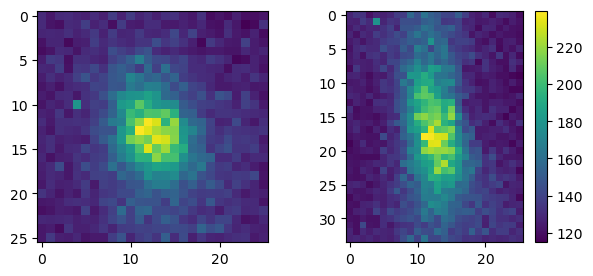

(34, 26, 26)
planes_10_z_36_y_971_x_809 161.0


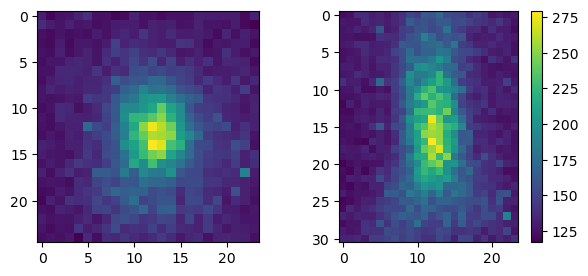

(31, 25, 24)
planes_10_z_35_y_1005_x_553 128.0


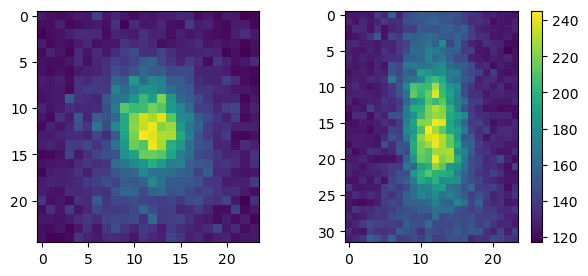

(32, 25, 24)
planes_10_z_29_y_1494_x_477 145.0


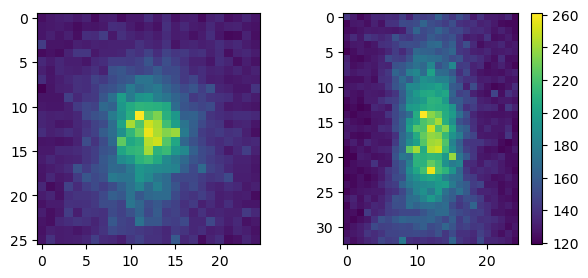

(33, 26, 25)
planes_10_z_42_y_401_x_171 132.0


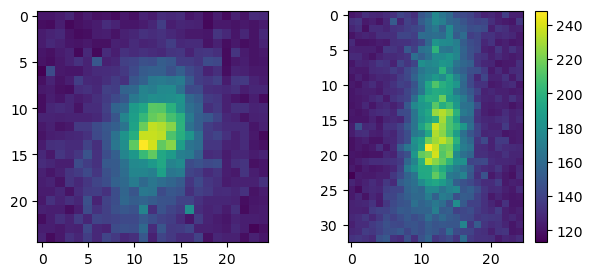

(33, 25, 25)
planes_10_z_32_y_1373_x_1001 155.0


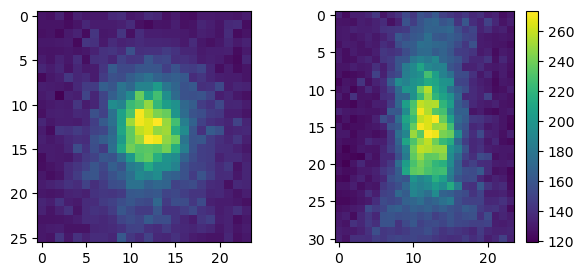

(31, 26, 24)
planes_10_z_32_y_1758_x_841 132.0


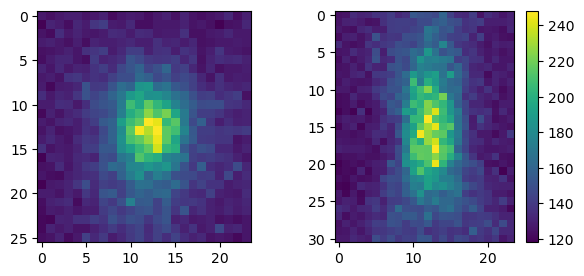

(31, 26, 24)
planes_10_z_30_y_261_x_1939 113.0


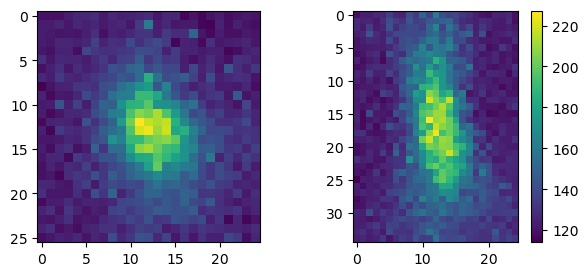

(35, 26, 25)
planes_10_z_30_y_1605_x_289 132.0


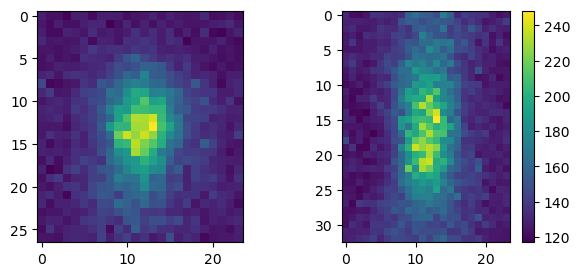

(33, 27, 24)
planes_10_z_36_y_1038_x_768 171.0


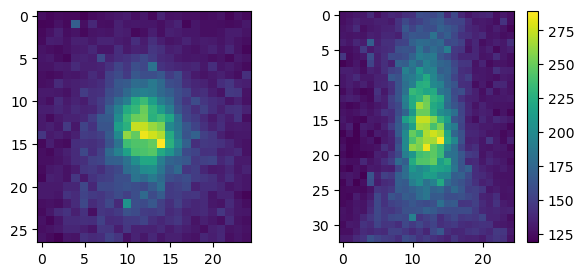

(33, 27, 25)
planes_10_z_37_y_160_x_1017 176.0


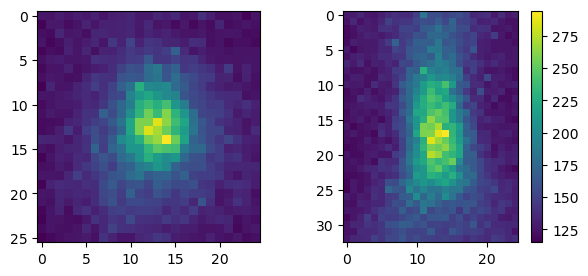

(33, 26, 25)
planes_10_z_35_y_1227_x_369 143.0


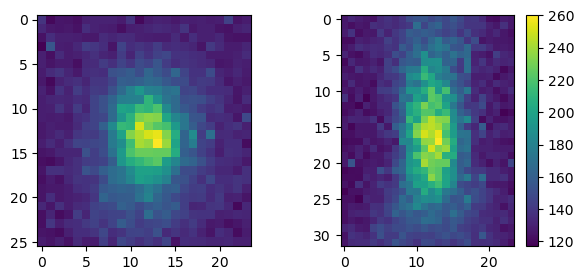

(32, 26, 24)
planes_10_z_32_y_1588_x_1275 178.0


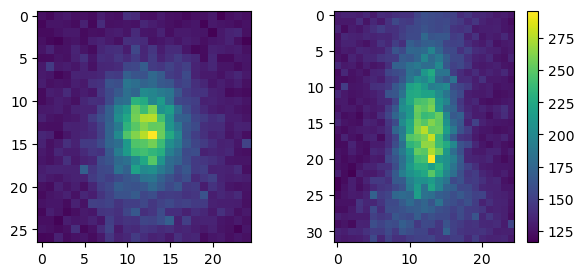

(32, 27, 25)
planes_10_z_32_y_917_x_1010 157.0


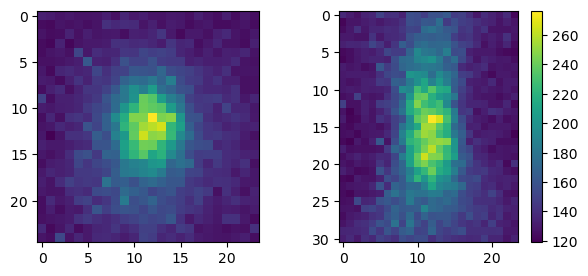

(31, 25, 24)
planes_10_z_29_y_835_x_1517 168.0


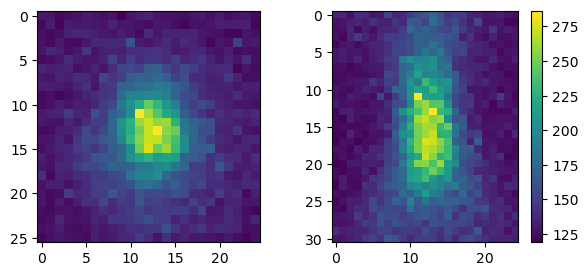

(31, 26, 25)
planes_10_z_36_y_1065_x_181 162.0


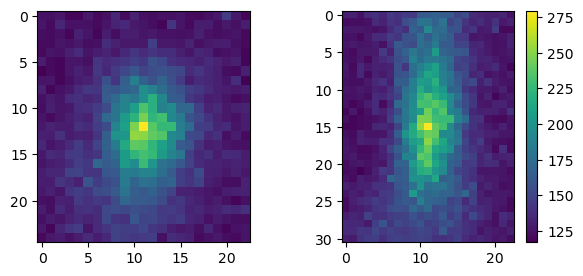

(31, 25, 23)
planes_10_z_36_y_922_x_252 145.0


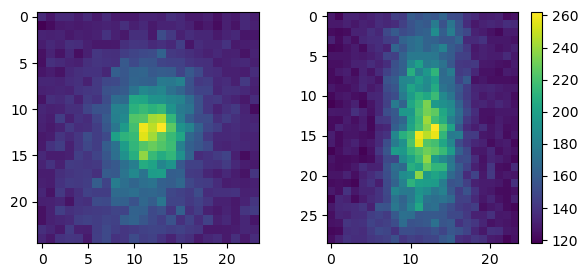

(29, 25, 24)
planes_10_z_41_y_514_x_462 133.0


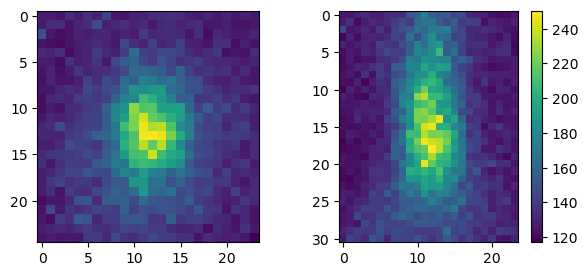

(31, 25, 24)
planes_10_z_34_y_1160_x_511 142.0


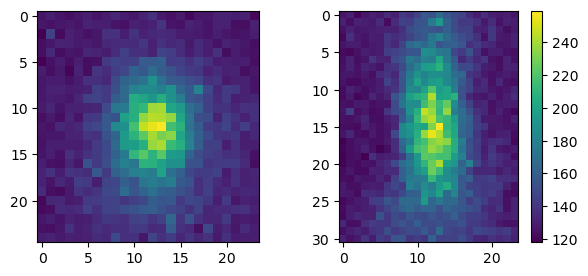

(31, 25, 24)
planes_10_z_39_y_1076_x_243 137.0


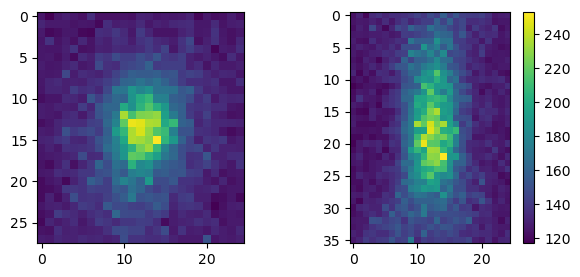

(36, 28, 25)


In [39]:
i=0
for n,pat in crops.items():
    zz,yy,xx = pat.shape
    x_arr = np.arange(-1*yy//2, yy//2)
    z_arr = np.arange(-1*zz//2, zz//2)
    fig, axs = plt.subplots(1,2,figsize=(7,3))
    print(n, np.max(pat) - np.median(pat))
    # print(shannon_entropy(pat))
    axs[0].imshow(np.max(pat,0))
    im = axs[1].imshow(np.max(pat,1))
    plt.colorbar(im)
    plt.show()
    print(pat.shape)
    i=i+1
    if i==50:
        break
None;

## Plot the signal-to-noise distribution

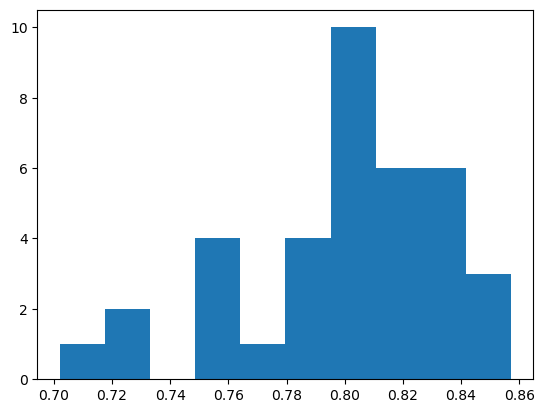

In [40]:
snr = []
for key,val in crops.items():
    val = min_max_norm(val)
    snr.append(np.max(val) - np.median(val))
snr = np.array(snr)
plt.hist(snr.flatten());

## Run Zola macro via bash command on the remote

Runs via ssh on the remote cluster: CBG HPC.

Calls a macro to run an ImageJ plugin on gpu nodes of the HPC cluster in headless batch mode. 

Uses `https://github.com/imodpasteur/ZOLA-3D` plugin: put the file

`ZOLA_-0.2.8-SNAPSHOT.jar`

into the plugins directory.

Uses the ImageJ executable stored in the variable 'remote_fiji_path'

Feeds the paramters and file locations to the macro, so no need to modify the macro for each experiment.

**Logistics**

1. Copy the folder `patches_for_zola` to the remote using ssh (needs to be set up with ssh passkeys between local and remote (falcon). Remove the `patches_for_zola` folder from the remote before copying, if it exists. 
2. slurm calls a bashscript shell script to initialize processes on the cluster: <br> `sbatch {remote_project_path}/scripts/bashscript3.sh`
2. In turn, the bash script sets up slurm jobs on gpu nodes of the cluster and calls ImageJ to run a macro stored in the variable `remote_fiji_macro_path` in headless batch mode.
3. The ImageJ macro runs the "Calibration: PSF modeling" plugin from the with the parameters stored in the `imageJ_macro_parameters` variable.  The macro should **not** need to be modified for each experiment.
4. The ImageJ plugin models the zola_raw data for each bead in the `zola_raw` folder
5. Copy the `zola_raw` folder from the cluster to the local machine using sftp and paramiko.  
 

In [41]:
# remove remote patches folder & files
! ssh falcon "rm -r {remote_patches_path}"

rm: cannot remove ‘/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/’: No such file or directory


In [42]:
# ! ls -lga "{local_patches_path}"

In [43]:
! scp -r "$local_patches_path" falcon:$remote_data_file_path

planes_14_z_34_y_1151_x_742.tif               100%   96KB   3.5MB/s   00:00    
planes_10_z_34_y_1151_x_742.tif               100%   76KB   2.7MB/s   00:00    
planes_12_z_34_y_1151_x_742.tif               100%   86KB   6.0MB/s   00:00    
planes_12_z_36_y_523_x_1042.tif               100%   91KB   5.4MB/s   00:00    
planes_10_z_36_y_523_x_1042.tif               100%   81KB   4.0MB/s   00:00    
planes_14_z_36_y_523_x_1042.tif               100%  101KB   6.9MB/s   00:00    
planes_14_z_25_y_1828_x_1514.tif              100%   93KB   7.0MB/s   00:00    
planes_10_z_25_y_1828_x_1514.tif              100%   73KB   4.5MB/s   00:00    
planes_12_z_25_y_1828_x_1514.tif              100%   83KB   7.5MB/s   00:00    
planes_12_z_29_y_1746_x_1181.tif              100%   86KB   6.2MB/s   00:00    
planes_10_z_29_y_1746_x_1181.tif              100%   76KB 534.4KB/s   00:00    
planes_14_z_29_y_1746_x_1181.tif              100%   96KB   3.0MB/s   00:00    
planes_12_z_38_y_425_x_148.tif          

### Troubleshooting / Testing ###

**Test Deb's ImageJ macro**

Note: to use the "run_on_gpu" option for the zola Fiji plugin in this line of the macro:

```python

	run(" Calibration: PSF modeling", "run_on_gpu gain=1 pixel_size=100 z_step=50 bead_moving=[far -> close to objective] numerical_aperture=1.2 immersion_refractive=1.33 wavelength=0.515 patch_size="+wid+" zernike_coefficient=[Zernike 15 coefs] iteration=100 result_calibration_file="+output);
```

you need to be logged into a gpu system on the cluster or implement the bashscript_fiji.sh (and derivatives) with sbatch on cluster (the script requests a gpu).

In [44]:
# i = 19
# INPUT_DIR=f"{remote_save_dir}patches_for_zola/patches_{i}"
# INPUT_DIR
# remote_zola_script_path
# # remote_imageJ_macro_parameter_string = shlex.quote(f"{INPUT_DIR},{imageJ_macro_parameters}")
# # remote_imageJ_macro_parameter_string = f'param0,param1'
# remote_imageJ_macro_parameter_string =  f"{INPUT_DIR},{imageJ_macro_parameters}"
# remote_imageJ_macro_parameter_string
# # print(remote_imageJ_macro_parameter_string)
# print(f"sbatch {remote_zola_script_path} '{remote_fiji_path} {remote_fiji_macro_path} {remote_imageJ_macro_parameter_string}'")

In [45]:
# ! scp "{local_fiji_macro_path}" falcon:"{remote_fiji_macro_path}"
# ! scp "{local_zola_script_path}" falcon:"{remote_zola_script_path}"
# 
# # ! ssh falcon sbatch {remote_zola_script_path} '{remote_fiji_path} {remote_fiji_macro_path} {remote_imageJ_macro_parameter_string}'

In [46]:
# ! ssh falcon "squeue -u jwhite"

In [47]:
# !ssh falcon "scancel 48960858"

In [48]:
# be sure the std/ directory exists
# !sbatch  -J {i} -e std/{i}.err -o std/{i}.out /home/jwhite/projects/aberration_mapping/scripts/bashscript_fiji.sh {FIJI_MACRO_PATH} {INPUT_DIR}

### Run Zola analysis on cluster ###

In [49]:
# copy fiji macro and zola bashscript to remote
! scp "{local_fiji_macro_path}" falcon:"{remote_fiji_macro_path}"
! scp "{local_zola_script_path}" falcon:"{remote_zola_script_path}"

zola_macro_cluster_params_passed.ijm          100% 2306   441.3KB/s   00:00    
bashscript_fiji3.sh                           100%  570   103.7KB/s   00:00    


In [50]:
# remove existing zola folder and create a new one
remote_zola_raw_folder = f"{remote_save_dir}patches_for_zola/zola_raw/"
# remote_zola_raw_folder
! ssh falcon "rm -r {remote_zola_raw_folder}; mkdir {remote_zola_raw_folder}" 

rm: cannot remove ‘/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/zola_raw/’: No such file or directory


In [51]:
! ssh falcon "ls -lga {remote_save_dir}"

total 663596
drwxr-sr-x  3 project-jwhite      4096 Oct  6 14:35 .
drwxrwsr-x 14 project-jwhite      4096 Oct  6 13:31 ..
-rwxr--r--  1 project-jwhite 679491471 Oct  6 13:33 0p5mk.tif
drwxr-xr-x 53 project-jwhite      4096 Oct  6 14:36 patches_for_zola
-rwxr--r--  1 project-jwhite       515 Oct  6 13:33 Results.csv


In [52]:
# Deleting the zola_raw folder and creating a new one
# shutil.rmtree(f"{save_dir}/patches_for_zola/zola_raw/", ignore_errors=True)
# os.makedirs(  f"{save_dir}/patches_for_zola/zola_raw/")
# 
# INPUT_DIR=f"{save_dir}/patches_for_zola/patches_{i}"

In [53]:
# not sure why Debayan had jobs split into two groups
#
# ***** be sure the std/ directory exists *****
#
# running zola on all the patches
for i in range(35):
# for i in [28]:
# for i in range(1):
# for i in range(0,num_folders):
    INPUT_DIR=f"{remote_save_dir}patches_for_zola/patches_{i}"
    print(INPUT_DIR)
    remote_imageJ_macro_parameter_string =  f"{INPUT_DIR},{imageJ_macro_parameters}"
    # !sbatch -J {i} -e std/{i}.err -o std/{i}.out {zola_script_path} {FIJI_MACRO_PATH} {INPUT_DIR}
    ! ssh falcon sbatch {remote_zola_script_path} '{remote_fiji_path} {remote_fiji_macro_path} {remote_imageJ_macro_parameter_string}'    
    print()
#     break

for i in range(35, num_folders):
    INPUT_DIR=f"{remote_save_dir}patches_for_zola/patches_{i}"
    print(INPUT_DIR)
    remote_imageJ_macro_parameter_string =  f"{INPUT_DIR},{imageJ_macro_parameters}"
    # print(zola_script_path)
    # !sbatch -J {i} -e std/{i}.err -o std/{i}.out {zola_script_path} {FIJI_MACRO_PATH} {INPUT_DIR}
    ! ssh falcon sbatch {remote_zola_script_path} '{remote_fiji_path} {remote_fiji_macro_path} {remote_imageJ_macro_parameter_string}'
    print()

/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/patches_0
Submitted batch job 48961005

/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/patches_1
Submitted batch job 48961006

/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/patches_2
Submitted batch job 48961007

/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/patches_3
Submitted batch job 48961008

/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/patches_4
Submitted batch job 48961009

/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/patches_5
Submitted batch job 48961010

/home/jwhite/projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/patches_for_zola/patches_6
Submitted batch job 48961011

/home/jwhite/projects/aberration_m

In [54]:
! ssh falcon "squeue -u jwhite"

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          48961054       gpu      PSF   jwhite PD       0:00      1 (None)
          48961053       gpu      PSF   jwhite PD       0:00      1 (Priority)
          48961052       gpu      PSF   jwhite PD       0:00      1 (Resources)
          48961006       gpu      PSF   jwhite  R       1:08      1 r02n16
          48961005       gpu      PSF   jwhite  R       1:11      1 r02n14
          48961051       gpu      PSF   jwhite  R       0:06      1 r02n11
          48961050       gpu      PSF   jwhite  R       0:07      1 r02n08
          48961047       gpu      PSF   jwhite  R       0:09      1 r02n10
          48961048       gpu      PSF   jwhite  R       0:09      1 r02n10
          48961049       gpu      PSF   jwhite  R       0:09      1 r02n11
          48961045       gpu      PSF   jwhite  R       0:12      1 r02n09
          48961046       gpu      PSF   jwhite  R       0:12      1 r02n09
      

In [55]:
# l = !ssh falcon "squeue -u jwhite"
# l = l[1:]
# l

In [56]:
# # monitor progress....
# l = !ssh falcon "squeue -u jwhite"
# l = l[1:]
# n = len(l)
# while n > 0:
#     clear_output(wait=False)
#     l = !ssh falcon "squeue -u jwhite"
#     l = l[1:]
#     n=len(l)
#     display(f'{n} files to go')
#     sleep(1)

## Write current parameters to `params.json`

In [60]:
local_data_file_path

'/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/'

In [75]:
# Write to params file
params = {
    'crop_shape':crop_shape, 
    'unit':unit, 
    'abb_list': abb_list, 
    'fiji_macro': fiji_macro, 
    'COMPUTERNAME' : socket.gethostname(),
    'thresh_bck':thresh_bck, 
    'lam':lam, 
    'thresh_dist':thresh_dist
}

parameter_file = "Parameters.json"
local_param_file_path = f'{local_data_file_path}{parameter_file}'
remote_param_file_path = f"{remote_data_file_path}{parameter_file}"

write_to_param_file(local_param_file_path, params)
print(local_param_file_path)
! scp '{local_param_file_path}' falcon:{remote_param_file_path}

/Users/jwhite/Library/Mobile Documents/com~apple~CloudDocs/Science/Grill_Lab/Projects/aberration_mapping/data/andrea/0p5mkBeadsDICHmirror_4_test/Parameters.json
Parameters.json                               100%  250    56.2KB/s   00:00    


Parameters.json                               100%  250    44.9KB/s   00:00    


## Sample Fiji macro

```
/*
 * @Debayan MPI-CBG
 */

file_path = getArgument();
print("In macro");
print(file_path);
processFolder(file_path); 

// function to scan folders/subfolders/files to find files with correct suffix
function processFolder(input) {
	start = getTime();
	print(input)
	list = getFileList(input);
	list = Array.sort(list);
	print(list.length)
	for (i = 0; i < list.length; i++) {
		print(list[i]);
		if(File.isDirectory(input + File.separator + list[i])){
			l = substring(list[i], 0, lengthOf(list[i])-1);
			processFolder(input + File.separator + l + File.separator);
		}
		if(endsWith(list[i], ".tif")){
			processFile(input, list[i]);
		}
	}
	print("Totoal Time: "+(getTime()-start)/1000);   
}

function processFile(input, file) {
	print("Processing: "+ input + File.separator + file);
	if (indexOf(input, "patches") > 0) {
		if (!File.exists(File.getParent(input) + File.separator + "zola_raw")){
			File.makeDirectory(File.getParent(input) + File.separator + "zola_raw"); 
		}
	output = File.getParent(input) + File.separator + "zola_raw"+ File.separator + substring(file, 0, indexOf(file, '.tif'))+'.json';
	print(output);

	open(input + File.separator + file);
	setSlice((nSlices+1)/2); 
	makePoint(getWidth()/2, getHeight()/2);
	wid = 64;
	run(" Calibration: PSF modeling", "run_on_gpu gain=1 pixel_size=200 z_step=50 bead_moving=[far -> close to objective] numerical_aperture=1.2 immersion_refractive=1.33 wavelength=0.515 patch_size="+wid+" zernike_coefficient=[Zernike 15 coefs] iteration=20 result_calibration_file="+output);
	run("Close All");
	}
	else{print("No patches");
	}
}

```

## Sample Zola bash scripts ##



**`/projects/project-dsaha/insitu_psf/bashscript_fiji.sh`**

```
#!/bin/bash
#SBATCH -J "One"
#SBATCH -t 8:00:00
#SBATCH -n 1
#SBATCH -N 1
#SBATCH --partition=gpu
#SBATCH --gres=gpu:1
#SBATCH --mem 1000


#export OPENBLAS_NUM_THREADS=4

module unload cuda
module load cuda/10.0.130
#module load cuda/9.0.176

echo "Starting Fiji script"


FIJI_MACRO_FILEPATH=$1
PATCHES_FOLDER_PATH=$2
echo ${FIJI_MACRO_FILEPATH}
echo ${PATCHES_FOLDER_PATH}
echo "Bashscript"
/projects/project-dsaha/Fiji_jobs/Fiji.app/ImageJ-linux64 --headless -batch ${FIJI_MACRO_FILEPATH} ${PATCHES_FOLDER_PATH}

echo "Finishing Fiji script"

```

**`/home/jwhite/projects/aberration_mapping/scripts/bashscript_fiji.sh`**

```
#!/bin/bash
#SBATCH -J "One"
#SBATCH -t 8:00:00
#SBATCH -n 1
#SBATCH -N 1
#SBATCH --partition=gpu
#SBATCH --gres=gpu:1
#SBATCH --mem 1000


#export OPENBLAS_NUM_THREADS=4

module unload cuda
module load cuda/10.0.130
#module load cuda/9.0.176

echo "Starting Fiji script"


FIJI_MACRO_FILEPATH=$1
PATCHES_FOLDER_PATH=$2
echo ${FIJI_MACRO_FILEPATH}
echo ${PATCHES_FOLDER_PATH}
echo "Bashscript"
/home/jwhite/fiji/Fiji.app/ImageJ-linux64 --headless -batch ${FIJI_MACRO_FILEPATH} ${PATCHES_FOLDER_PATH}

echo "Finishing Fiji script"


```

**`/projects/project-dsaha/insitu_psf/bashscript_fiji_short.sh`**

```
#!/bin/bash
#SBATCH -J "One"
#SBATCH -t 1:00:00
#SBATCH -n 1
#SBATCH -N 1
#SBATCH --partition=short
#SBATCH --gres=gpu:1
#SBATCH --mem 5000


#export OPENBLAS_NUM_THREADS=4

module unload cuda
module load cuda/10.0.130
#module load cuda/9.0.176

echo "Starting Fiji script"


FIJI_MACRO_FILEPATH=$1
PATCHES_FOLDER_PATH=$2
echo ${FIJI_MACRO_FILEPATH}
echo ${PATCHES_FOLDER_PATH}
echo "Bashscript"
/projects/project-dsaha/Fiji_jobs/Fiji.app/ImageJ-linux64 --headless -batch ${FIJI_MACRO_FILEPATH} ${PATCHES_FOLDER_PATH}

echo "Finishing Fiji script"


```

# End #